In [1]:
import cons
import os
import time
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

In [2]:
from utilities.gen_master_data import gen_master_data
from utilities.preaggregate_data import preaggregate_data
from utilities.time_data import time_data
from utilities.time_plot import time_plot
from utilities.timeit import timeit
from utilities.gen_counties_data import gen_counties_data
from utilities.map_plot import map_plot

In [3]:
# load master data
data = pd.read_feather(cons.master_data_fpath)

In [4]:
# load preaggregated data
with open(cons.preaggregate_data_fpath, "rb") as f:
    pre_agg_data_dict = pickle.load(f)

# Aggregate Time-Series Data

In [5]:
date_strftime_dict = cons.date_strftime_dict
counties = cons.counties
agg_dict = {col:'mean' for col in cons.col_options}

### Year Level Data

In [6]:
year_strftime = date_strftime_dict['year']
time_span = ['2010', '2019']

In [7]:
# raw data
params_dict = {'data':data, 'agg_dict':agg_dict, 'time_span':time_span, 'counties':counties, 'strftime':year_strftime}
year_data = timeit(func = time_data, params = params_dict, itr = 20)

Mean Execution Time: 2.005 seconds


In [8]:
# pre-aggregated data
params_dict = {'data':pre_agg_data_dict['mean'], 'agg_dict':agg_dict, 'time_span':time_span, 'counties':counties, 'strftime':year_strftime}
year_data = timeit(func = time_data, params = params_dict, itr = 20)

Mean Execution Time: 0.023 seconds


In [9]:
year_data.shape

(40, 12)

## Month Level Data

In [10]:
month_strftime = date_strftime_dict['month']
time_span = ['01', '12']

In [11]:
# raw data
params_dict = {'data':data, 'agg_dict':agg_dict, 'time_span':time_span, 'counties':counties, 'strftime':month_strftime}
month_data = timeit(func = time_data, params = params_dict, itr = 20)

Mean Execution Time: 1.991 seconds


In [12]:
# pre-aggregated data
params_dict = {'data':pre_agg_data_dict['mean'], 'agg_dict':agg_dict, 'time_span':time_span, 'counties':counties, 'strftime':month_strftime}
month_data = timeit(func = time_data, params = params_dict, itr = 20)

Mean Execution Time: 0.024 seconds


In [13]:
month_data.shape

(48, 12)

# Time Series Plots

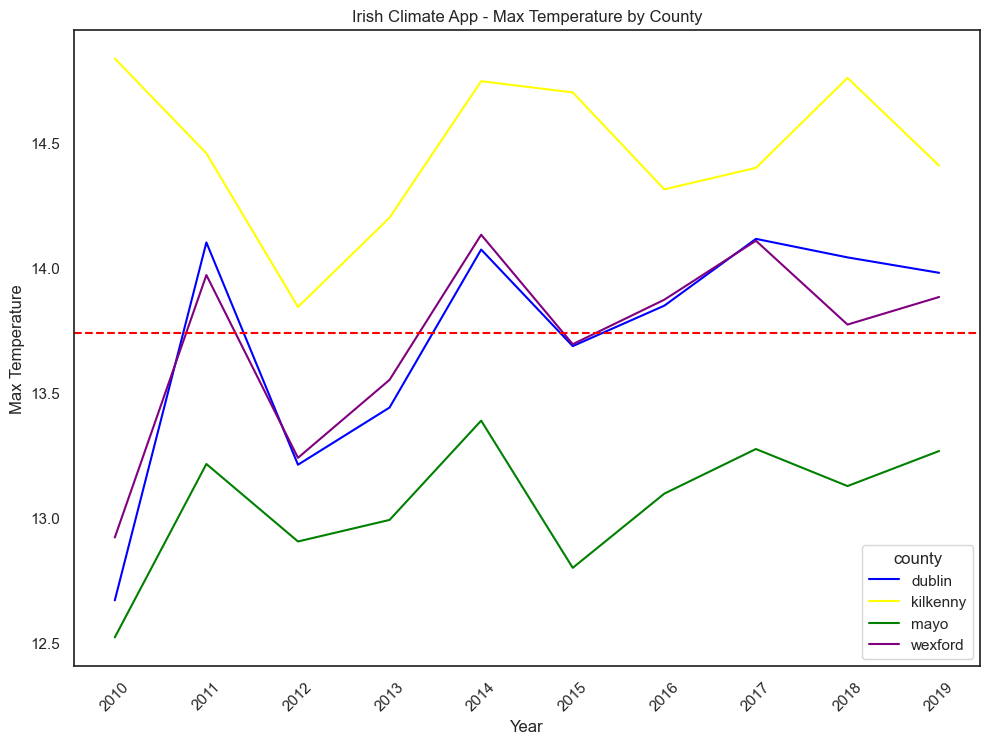

0

In [14]:
time_plot(data = year_data, 
          x = 'index', 
          y = 'maxtp', 
          hue = 'county', 
          strftime = year_strftime, 
          refline = year_data['maxtp'].mean(), 
          title = 'Irish Climate App - Max Temperature by County',
          xlabel = 'Year',
          ylabel = 'Max Temperature'
         )

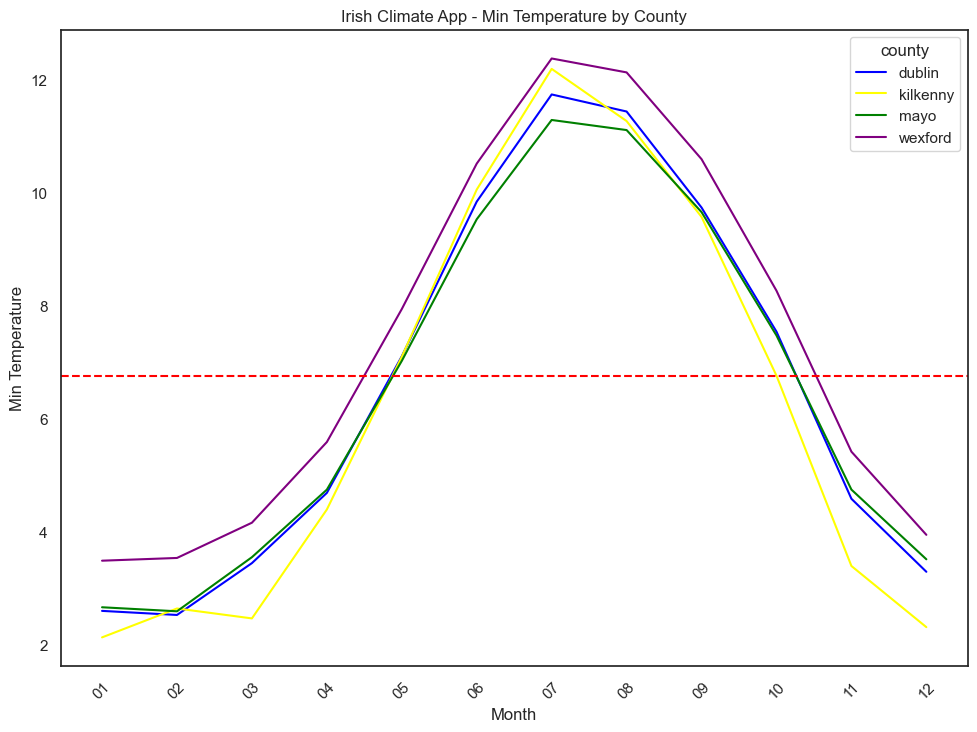

0

In [15]:
time_plot(data = month_data, 
          x = 'index',
          y = 'mintp', 
          hue = 'county', 
          strftime = year_strftime, 
          refline = year_data['mintp'].mean(), 
          title = 'Irish Climate App - Min Temperature by County',
          xlabel = 'Month',
          ylabel = 'Min Temperature'
         )

# GIS Heat Map

In [17]:
# load preaggregated data
with open(cons.map_data_fpath, "rb") as f:
    map_data_dict = pickle.load(f)

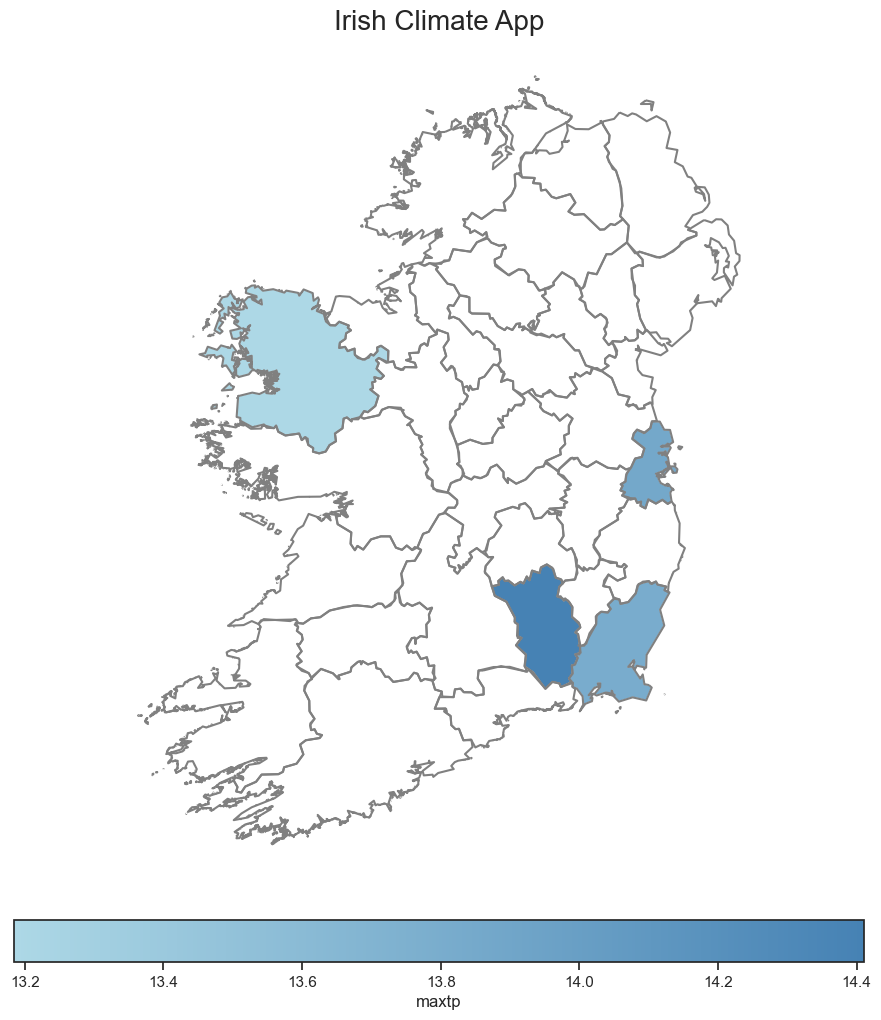

0

In [18]:
map_plot(map_data_dict, stat = 'mean', col = 'maxtp')